In [1]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
import pandas as pd
import numpy as np
import torch.fft
import subprocess
import logging
import random
import shutil
import psutil
import scipy
import torch
import copy
import yaml
import time
import tqdm
import sys
import gc


from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from holodecml.data import PickleReader, UpsamplingReader
from holodecml.propagation import InferencePropagator
from holodecml.transforms import LoadTransformations
from holodecml.models import load_model
from holodecml.losses import load_loss

import os
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
available_ncpus = len(psutil.Process().cpu_affinity())

In [3]:
# ### Set seeds for reproducibility
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True

In [4]:
config = "../results/gan/model.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [29]:
# Set seeds for reproducibility
seed = 1000 if "seed" not in conf else conf["seed"]
seed_everything(seed)

tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])
data_path = conf["data"]["output_path"]

total_positive = int(conf["data"]["total_positive"])
total_negative = int(conf["data"]["total_negative"])
total_examples = int(conf["data"]["total_training"])

transform_mode = "None" if "transform_mode" not in conf["data"] else conf["data"]["transform_mode"]
config_ncpus = int(conf["data"]["cores"])
use_cached = False if "use_cached" not in conf["data"] else conf["data"]["use_cached"]

name_tag = f"{tile_size}_{step_size}_{total_positive}_{total_negative}_{total_examples}_{transform_mode}"
fn_train = f"{data_path}/training_{name_tag}.pkl"
fn_valid = f"{data_path}/validation_{name_tag}.pkl"

output_path = conf["data"]["output_path"]

train_batch_size = 32
valid_batch_size = 32

latent_dim = 1024
img_shape = (1, tile_size, tile_size)

d_learning_rate = 0.0004
g_learning_rate = 0.0001

b1 = 0.0
b2 = 0.9

In [30]:
is_cuda = torch.cuda.is_available()
data_device = torch.device("cpu") if "device" not in conf["data"] else conf["data"]["device"]

In [31]:
# Load the preprocessing transforms
if "Normalize" in conf["transforms"]["training"]:
    conf["transforms"]["validation"]["Normalize"]["mode"] = conf["transforms"]["training"]["Normalize"]["mode"]
    conf["transforms"]["inference"]["Normalize"]["mode"] = conf["transforms"]["training"]["Normalize"]["mode"]

train_transforms = LoadTransformations(conf["transforms"]["training"])
valid_transforms = LoadTransformations(conf["transforms"]["validation"])

In [32]:
# train_synthetic_dataset = UpsamplingReader(
#     conf,
#     transform=train_transforms,
#     max_size=100,
#     device=data_device
# )

train_synthetic_dataset = PickleReader(
    fn_train,
    transform=train_transforms,
    max_images=int(0.8 * conf["data"]["total_training"]),
    max_buffer_size=int(0.1 * conf["data"]["total_training"]),
    color_dim=conf["model"]["in_channels"],
    shuffle=True
)

test_synthetic_dataset = PickleReader(
    fn_valid,
    transform=valid_transforms,
    max_images=int(0.1 * conf["data"]["total_training"]),
    max_buffer_size=int(0.1 * conf["data"]["total_training"]),
    color_dim=conf["model"]["in_channels"],
    shuffle=False
)

In [33]:
train_synthetic_loader = torch.utils.data.DataLoader(
    train_synthetic_dataset,
    batch_size=train_batch_size,
    num_workers=0, #available_ncpus//2,
    pin_memory=True,
    shuffle=True)

test_synthetic_loader = torch.utils.data.DataLoader(
    test_synthetic_dataset,
    batch_size=valid_batch_size,
    num_workers=0,  # 0 = One worker with the main process
    pin_memory=True,
    shuffle=False)

In [34]:
holo_conf = copy.deepcopy(conf)
holo_conf["data"]["data_path"] = holo_conf["data"]["raw_data"]

# class UpsamplingReaderLimited(UpsamplingReader):

#     def __len__(self):
#         return len(list(self.prop.h_ds["hid"].values))


train_holodec_dataset = UpsamplingReader(
    holo_conf,
    transform=train_transforms,
    max_size=100,
    device=data_device
)

test_holodec_inputs = torch.from_numpy(np.load(os.path.join(
            output_path, f'manual_images_{transform_mode}.npy'))).float()
test_holodec_labels = torch.from_numpy(np.load(os.path.join(
            output_path, f'manual_labels_{transform_mode}.npy'))).float()

test_holodec_dataset = torch.utils.data.TensorDataset(test_holodec_inputs, test_holodec_labels)

In [35]:
train_holodec_loader = torch.utils.data.DataLoader(
    train_holodec_dataset,
    batch_size=train_batch_size,
    num_workers=available_ncpus,
    pin_memory=True,
    shuffle=True)

test_holodec_loader = torch.utils.data.DataLoader(
    test_holodec_dataset,
    batch_size=valid_batch_size,
    num_workers=0,  # 0 = One worker with the main process
    pin_memory=True,
    shuffle=False)

In [ ]:
from torch.optim.optimizer import Optimizer, required
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim, activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = SpectralNorm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1))
        self.key_conv = SpectralNorm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1))
        self.value_conv = SpectralNorm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1))
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out, attention
    
# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1:
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find("BatchNorm2d") != -1:
#         torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
#         torch.nn.init.constant_(m.bias.data, 0.0)
        
# def weights_init_normal(m):
#     if isinstance(m, nn.Conv2d or nn.Linear):
#         torch.nn.init.xavier_normal_(m.weight)
#         m.bias.data.zero_()
#     elif isinstance(m, torch.nn.GRU or torch.nn.LSTM):
#         for name, param in m.named_parameters():
#             if 'bias' in name:
#                 torch.nn.init.constant_(param, 0.0)
#             elif 'weight_ih' in name:
#                 torch.nn.init.kaiming_normal_(param)
#             elif 'weight_hh' in name:
#                 torch.nn.init.orthogonal_(param)
#     elif isinstance(m, torch.nn.BatchNorm2d or torch.nn.BatchNorm1d):
#         m.weight.data.fill_(1)
#         m.bias.data.zero_()


# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.init_size = tile_size // 4
#         self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
#         self.attn1 = Self_Attn( 128 * 8, 'relu')

#         self.conv_blocks = nn.Sequential(
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2),
#             SpectralNorm(nn.Conv2d(128, 128, 3, stride=1, padding=1)),
#             nn.BatchNorm2d(128, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Upsample(scale_factor=2),
#             SpectralNorm(nn.Conv2d(128, 64, 3, stride=1, padding=1)),
#             nn.BatchNorm2d(64, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             SpectralNorm(nn.Conv2d(64, 1, 3, stride=1, padding=1)),
#             nn.Tanh(),
#         )

#     def forward(self, z):
#         out = self.l1(z)
#         out = out.view(out.shape[0], 128, self.init_size, self.init_size)
#         img = self.conv_blocks(out)
#         return img


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, bn=True):
#             block = [SpectralNorm(nn.Conv2d(in_filters, out_filters, 3, 2, 1)), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
#             if bn:
#                 block.append(nn.BatchNorm2d(out_filters, 0.8))
#             return block

#         self.model = nn.Sequential(
#             *discriminator_block(1, 16, bn=False),
#             *discriminator_block(16, 32),
#             *discriminator_block(32, 64),
#             *discriminator_block(64, 128),
#         )

#         # The height and width of downsampled image
#         ds_size = tile_size // 2 ** 4
#         self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

#     def forward(self, img):
#         out = self.model(img)
#         out = out.view(out.shape[0], -1)
#         validity = self.adv_layer(out)
#         return validity
    
    
    
class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size = 32, image_size=512, z_dim=128, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        layer4 = []
        layer5 = []
        layer6 = []
        layer7 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.LeakyReLU(0.2, inplace=True))
        #layer1.append(nn.Dropout2d(0.25))

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.LeakyReLU(0.2, inplace=True))
        #layer2.append(nn.Dropout2d(0.25))

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.LeakyReLU(0.2, inplace=True))
        #layer3.append(nn.Dropout2d(0.25))
        
        curr_dim = int(curr_dim / 2)

        layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer4.append(nn.LeakyReLU(0.2, inplace=True))
        #layer4.append(nn.Dropout2d(0.25))
        
        curr_dim = int(curr_dim / 2)

        layer5.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer5.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer5.append(nn.LeakyReLU(0.2, inplace=True))
        #layer5.append(nn.Dropout2d(0.25))
        
        curr_dim = int(curr_dim / 2)

        layer6.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer6.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer6.append(nn.LeakyReLU(0.2, inplace=True))
        #layer6.append(nn.Dropout2d(0.25))
        
        curr_dim = int(curr_dim / 2)
        
        layer7.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer7.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer7.append(nn.LeakyReLU(0.2, inplace=True))
        #layer7.append(nn.Dropout2d(0.25))
        
        curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)
        self.l4 = nn.Sequential(*layer4)
        self.l5 = nn.Sequential(*layer5)
        self.l6 = nn.Sequential(*layer6)
        self.l7 = nn.Sequential(*layer7)

        last.append(nn.ConvTranspose2d(curr_dim, 1, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 512 * 8, 'relu')
        self.attn2 = Self_Attn( 256 * 8, 'relu')
        self.attn3 = Self_Attn( 128 * 8, 'relu')
        self.attn4 = Self_Attn( 64 * 8,  'relu')
        #self.attn4 = Self_Attn( 32 * 8, 'relu')
        #self.attn5 = Self_Attn( 16 * 8, 'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        #out, _ = self.attn1(out)
        out=self.l2(out)
        #out, _ = self.attn2(out)
        out=self.l3(out)
        #out, _ = self.attn3(out)
        out=self.l4(out)
        #out, _ = self.attn4(out)
        out = self.l5(out)
        #out,p5 = self.attn5(out)
        out = self.l6(out)
        out = self.l7(out)
        out=self.last(out)
        return out


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, color_dim = 1, batch_size=32, image_size=512, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        layer4 = []
        layer5 = []
        layer6 = []
        layer7 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(color_dim, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))
        layer1.append(nn.Dropout2d(0.25))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        layer2.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        layer3.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2
        
        layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer4.append(nn.LeakyReLU(0.1))
        layer4.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2
        
        layer5.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer5.append(nn.LeakyReLU(0.1))
        layer5.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2
        
        layer6.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer6.append(nn.LeakyReLU(0.1))
        layer6.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2
        
        layer7.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer7.append(nn.LeakyReLU(0.1))
        layer7.append(nn.Dropout2d(0.25))
        curr_dim = curr_dim * 2
            
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)
        self.l4 = nn.Sequential(*layer4)
        self.l5 = nn.Sequential(*layer5)
        self.l6 = nn.Sequential(*layer6)
        self.l7 = nn.Sequential(*layer7)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        #self.attn1 = Self_Attn(128, 'relu')
        #self.attn2 = Self_Attn(256, 'relu')
        self.attn3 = Self_Attn(512, 'relu')
        self.attn4 = Self_Attn(1024, 'relu')
        self.attn5 = Self_Attn(2048, 'relu')
        self.attn6 = Self_Attn(4096, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        #out, p1 = self.attn1(out)
        out = self.l3(out)
        #out, p2 = self.attn2(out)
        out = self.l4(out)
        #out, _ = self.attn3(out)
        out = self.l5(out)
        #out, _ = self.attn4(out)
        out = self.l6(out)
        #out, _ = self.attn5(out)
        out = self.l7(out)
        #out, _ = self.attn6(out)
        out = self.last(out)

        return out.squeeze()
    
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [14]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if is_cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    
# Initialize weights
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

In [15]:
optimizer_G = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=g_learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()), lr=d_learning_rate, betas=(b1, b2))

In [16]:
n_epochs = 1000
batches_per_epoch = 100

sample_interval = 10
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor
adv_loss = 'wgan-gp'
lambda_gp = 10
train_gen_every = 5

for epoch in range(n_epochs):
    
    real_images = enumerate(train_holodec_loader)
    synthethic_images = iter(train_synthetic_loader)
    
    for i, (holo_img, holo_label) in real_images:
        
        try:
            synth_img, synth_label = next(synthethic_images)
        except:
            synthethic_images = iter(train_synthetic_loader)
            synth_img, synth_label = next(synthethic_images)
            
        if holo_img.shape[0] != synth_img.shape[0]:
            continue
                
        # Adversarial ground truths
        valid = Variable(Tensor(holo_img.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(holo_img.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(holo_img.type(Tensor))
        synthethic_imgs = Variable(synth_img.type(Tensor))
        
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (holo_img.shape[0], latent_dim))))
        # Generate a batch of images
        gen_noise = generator(z)
        # Add to the synthetic images
        gen_imgs = 0.5 * (synthethic_imgs + gen_noise)
        # Discriminate the fake images
        verdict = discriminator(gen_imgs)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        requires_grad(generator, True)
        requires_grad(discriminator, False)
        
        if (i + 1) % train_gen_every == 0 or i == 0:
            
            # Loss measures generator's ability to fool the discriminator
            if adv_loss == 'wgan-gp':
                g_loss = -verdict.mean()
            elif adv_loss == 'hinge':
                g_loss = -verdict.mean()
            elif adv_loss == 'bce':
                g_loss = adversarial_loss(verdict, valid)
            g_loss.backward()
            optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        requires_grad(generator, False)
        requires_grad(discriminator, True)
        
        # Measure discriminator's ability to classify real from generated samples
        if adv_loss == 'wgan-gp':
            real_loss = -torch.mean(discriminator(real_imgs))
            fake_loss = discriminator(gen_imgs.detach()).mean()
        elif adv_loss == 'hinge':
            real_loss = torch.nn.ReLU()(1.0 - discriminator(real_imgs)).mean()
            fake_loss = torch.nn.ReLU()(1.0 + discriminator(gen_imgs.detach())).mean()
        elif adv_loss == 'bce':
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()
        
        if adv_loss == 'wgan-gp':
            # Compute gradient penalty
            alpha = torch.rand(real_imgs.size(0), 1, 1, 1).cuda().expand_as(real_imgs)
            interpolated = Variable(alpha * real_imgs.data + (1 - alpha) * gen_imgs.data, requires_grad=True)
            out = discriminator(interpolated)

            grad = torch.autograd.grad(outputs=out,
                                       inputs=interpolated,
                                       grad_outputs=torch.ones(out.size()).cuda(),
                                       retain_graph=True,
                                       create_graph=True,
                                       only_inputs=True)[0]

            grad = grad.view(grad.size(0), -1)
            grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
            d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

            # Backward + Optimize
            d_loss_reg = lambda_gp * d_loss_gp

            optimizer_D.zero_grad()
            d_loss_reg.backward()
            optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, batches_per_epoch, d_loss.item(), g_loss.item())
        )
        
        if (i + 1) % sample_interval == 0:
            save_image(synthethic_imgs.data[:25], f"../results/gan/images/synth_{epoch}_{i}.png", nrow=5, normalize=True)
            save_image(real_imgs.data[:25], f"../results/gan/images/real_{epoch}_{i}.png", nrow=5, normalize=True)
            save_image(gen_imgs.data[:25], f"../results/gan/images/pred_{epoch}_{i}.png", nrow=5, normalize=True)
            
        with open("../results/gan/training_log.csv", "a+") as fid:
            fid.write(f"{epoch},{i},{d_loss.item()},{d_loss_reg.item()},{g_loss.item()}\n")
            
        if (i + 1) == batches_per_epoch:
            torch.save(generator.state_dict(), f'../results/gan/images/generator_{epoch}.pt')
            torch.save(discriminator.state_dict(), f'../results/gan/images/discriminator_{epoch}.pt')
            torch.save(optimizer_G.state_dict(), f'../results/gan/images/gen_optimizer_{epoch}.pt')
            torch.save(optimizer_D.state_dict(), f'../results/gan/images/dis_optimizer_{epoch}.pt')
            break

[Epoch 0/200] [Batch 0/100] [D loss: 0.002460] [G loss: 0.018491]
[Epoch 0/200] [Batch 1/100] [D loss: -0.038955] [G loss: 0.018491]
[Epoch 0/200] [Batch 2/100] [D loss: -0.243357] [G loss: 0.018491]
[Epoch 0/200] [Batch 3/100] [D loss: -3.100835] [G loss: 0.018491]
[Epoch 0/200] [Batch 4/100] [D loss: -8.437162] [G loss: -10.601519]
[Epoch 0/200] [Batch 5/100] [D loss: -17.570305] [G loss: -10.601519]
[Epoch 0/200] [Batch 6/100] [D loss: -33.810352] [G loss: -10.601519]
[Epoch 0/200] [Batch 7/100] [D loss: -46.744064] [G loss: -10.601519]
[Epoch 0/200] [Batch 8/100] [D loss: -55.848511] [G loss: -10.601519]
[Epoch 0/200] [Batch 9/100] [D loss: -70.385132] [G loss: -26.575256]
[Epoch 0/200] [Batch 10/100] [D loss: -83.034592] [G loss: -26.575256]
[Epoch 0/200] [Batch 11/100] [D loss: -103.663055] [G loss: -26.575256]
[Epoch 0/200] [Batch 12/100] [D loss: -104.241409] [G loss: -26.575256]
[Epoch 0/200] [Batch 13/100] [D loss: -102.394325] [G loss: -26.575256]
[Epoch 0/200] [Batch 14/100

RuntimeError: DataLoader worker (pid(s) 82426, 82427, 82432, 82437) exited unexpectedly

In [15]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np

In [25]:
with open("../results/gan/training_log.csv", "r") as fid:
    lines = np.array([[float(g) for g in f.strip("\n").split(",")] for f in fid.readlines()])

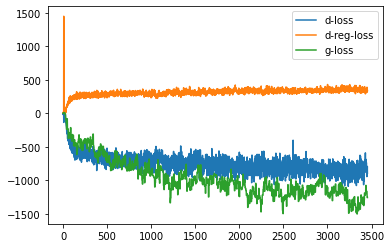

In [26]:
batch_updates = range(len(lines[:, 0]))

plt.plot(batch_updates, lines[:, 2])
plt.plot(batch_updates, lines[:, 3])
plt.plot(batch_updates, lines[:, 4])
plt.legend(["d-loss", "d-reg-loss", "g-loss"])

### Dual discriminator

In [39]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(z_dim = latent_dim)
discriminator = Discriminator(color_dim = 1)

if is_cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [40]:
optimizer_G = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=g_learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()), lr=d_learning_rate, betas=(b1, b2))

In [ ]:
n_epochs = 1000
batches_per_epoch = 100

sample_interval = 10
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor
adv_loss = 'wgan-gp'
lambda_gp = 10
train_gen_every = 5

for epoch in range(n_epochs):
    
    real_images = enumerate(train_holodec_loader)
    synthethic_images = iter(train_synthetic_loader)
    
    for i, (holo_img, holo_label) in real_images:
        
        try:
            synth_img, synth_label = next(synthethic_images)
        except:
            synthethic_images = iter(train_synthetic_loader)
            synth_img, synth_label = next(synthethic_images)
            
        if holo_img.shape[0] != synth_img.shape[0]:
            continue
                
        # Adversarial ground truths
        valid = Variable(Tensor(holo_img.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(holo_img.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(holo_img.type(Tensor))
        synthethic_imgs = Variable(synth_img.type(Tensor))
        
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (holo_img.shape[0], latent_dim))))
        # Generate a batch of images
        gen_noise = generator(z)
        # Add to the synthetic images
        gen_imgs = gen_noise #0.5 * (synthethic_imgs + gen_noise)
        # Discriminate the fake images
        verdict = discriminator(gen_imgs)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        requires_grad(generator, True)
        requires_grad(discriminator, False)
        
        if (i + 1) % train_gen_every == 0 or i == 0:
            
            # Loss measures generator's ability to fool the discriminator
            if adv_loss == 'wgan-gp':
                g_loss = -verdict.mean()
            elif adv_loss == 'hinge':
                g_loss = -verdict.mean()
            elif adv_loss == 'bce':
                g_loss = adversarial_loss(verdict, valid)
            g_loss.backward()
            optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        requires_grad(generator, False)
        requires_grad(discriminator, True)
        
        # Measure discriminator's ability to classify real from generated samples
        if adv_loss == 'wgan-gp':
            real_loss = -torch.mean(discriminator(synthethic_imgs))
            fake_loss = discriminator(gen_imgs.detach()).mean() / 2
            #fake_loss += discriminator(synthethic_imgs.detach()).mean() / 2
        elif adv_loss == 'hinge':
            real_loss = torch.nn.ReLU()(1.0 - discriminator(real_imgs)).mean()
            fake_loss = torch.nn.ReLU()(1.0 + discriminator(gen_imgs.detach())).mean() / 2
            #fake_loss += torch.nn.ReLU()(1.0 + discriminator(synthethic_imgs.detach())).mean() / 2
        elif adv_loss == 'bce':
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) / 2
            #fake_loss += adversarial_loss(discriminator(synthethic_imgs.detach()), fake) / 2
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()
        
        if adv_loss == 'wgan-gp':
            # Compute gradient penalty
            alpha = torch.rand(synthethic_imgs.size(0), 1, 1, 1).cuda().expand_as(synthethic_imgs)
            interpolated = Variable(alpha * synthethic_imgs.data + (1 - alpha) * gen_imgs.data, requires_grad=True)
            out = discriminator(interpolated)

            grad = torch.autograd.grad(outputs=out,
                                       inputs=interpolated,
                                       grad_outputs=torch.ones(out.size()).cuda(),
                                       retain_graph=True,
                                       create_graph=True,
                                       only_inputs=True)[0]

            grad = grad.view(grad.size(0), -1)
            grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
            d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

            # Backward + Optimize
            d_loss_reg = lambda_gp * d_loss_gp

            optimizer_D.zero_grad()
            d_loss_reg.backward()
            optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [D reg: %f] [G loss: %f]"
            % (epoch, n_epochs, i, batches_per_epoch, d_loss.item(), d_loss_reg.item(), g_loss.item())
        )
        
        if (i + 1) % sample_interval == 0:
            save_image(synthethic_imgs.data[:25], f"../results/gan/images/synth_{epoch}_{i}.png", nrow=5, normalize=True)
            save_image(real_imgs.data[:25], f"../results/gan/images/real_{epoch}_{i}.png", nrow=5, normalize=True)
            save_image(gen_imgs.data[:25], f"../results/gan/images/pred_{epoch}_{i}.png", nrow=5, normalize=True)
            
        with open("../results/gan/training_log.csv", "a+") as fid:
            fid.write(f"{epoch},{i},{d_loss.item()},{d_loss_reg.item()},{g_loss.item()}\n")
            
        if (i + 1) == batches_per_epoch:
            torch.save(generator.state_dict(), f'../results/gan/images/generator_{epoch}.pt')
            torch.save(discriminator.state_dict(), f'../results/gan/images/discriminator_{epoch}.pt')
            torch.save(optimizer_G.state_dict(), f'../results/gan/images/gen_optimizer_{epoch}.pt')
            torch.save(optimizer_D.state_dict(), f'../results/gan/images/dis_optimizer_{epoch}.pt')
            break

[Epoch 0/1000] [Batch 0/100] [D loss: -0.000258] [D reg: 8.509409] [G loss: -0.004816]
[Epoch 0/1000] [Batch 1/100] [D loss: -202.073975] [D reg: 3051.933838] [G loss: -0.004816]
[Epoch 0/1000] [Batch 2/100] [D loss: -101.769745] [D reg: 1.639710] [G loss: -0.004816]
[Epoch 0/1000] [Batch 3/100] [D loss: -154.818710] [D reg: 1.505449] [G loss: -0.004816]
[Epoch 0/1000] [Batch 4/100] [D loss: -253.639297] [D reg: 13.927910] [G loss: -266.518250]
[Epoch 0/1000] [Batch 5/100] [D loss: -370.689789] [D reg: 43.939140] [G loss: -266.518250]
[Epoch 0/1000] [Batch 6/100] [D loss: -501.073761] [D reg: 134.474579] [G loss: -266.518250]
[Epoch 0/1000] [Batch 7/100] [D loss: -627.082520] [D reg: 170.801880] [G loss: -266.518250]
[Epoch 0/1000] [Batch 8/100] [D loss: -832.774963] [D reg: 263.925476] [G loss: -266.518250]
[Epoch 0/1000] [Batch 9/100] [D loss: -1016.583374] [D reg: 357.937073] [G loss: -640.814575]
[Epoch 0/1000] [Batch 10/100] [D loss: -1047.090088] [D reg: 418.811279] [G loss: -640